# [Implementation and application patterns for explaining methods]()
-------
#### Software chapter of the "Interpretable AI: Interpreting, Explaining and Visualizing Deep Learning" book 
--------

This is the accompanying code for the software chapter of the book "Interpretable AI: Interpreting, Explaining and Visualizing Deep Learning". For a more detailed understanding please have a look into the chapter: [TODO: Add link.]().

-------

## Section 3.3

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models

import innvestigate
import innvestigate.applications.imagenet
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
imgnetutils = imp.load_source("utils_imagenet", "../utils_imagenet.py")

# We create many graphs, let's not run out of memory.
if keras.backend.backend() == "tensorflow":
    config = keras.backend.tf.ConfigProto()
    config.gpu_options.allow_growth = True
    keras.backend.set_session(keras.backend.tf.Session(config=config))

Using TensorFlow backend.


## Models, data and analyzers

We choose a set of ImageNet models:

In [3]:
# Choose a list of models
netnames = ["vgg16",
            "inception_v3",
            "resnet50",
            "densenet121",
            "nasnet_large",
           ]           
n_nets = len(netnames)

The following function will load a specific model, load the data in the respective format and create analyzers for this model.

**For a better understanding of this part we refer to the [Comparing networks on ImagenNet](imagenet_network_comparison.ipynb) notebook, from which this code segment is adopted from.**

In [4]:

import innvestigate.analyzer.relevance_based.relevance_rule as rrules
epsilon = 1

class CEpsilonRule(rrules.EpsilonRule):
    def __init__(self, *args, **kwargs):
        super(CEpsilonRule, self).__init__(*args, epsilon=epsilon, **kwargs)

def prepare_model_data_and_analyzers(netname):
    # Load the model definition.
    tmp = getattr(innvestigate.applications.imagenet, netname)
    net = tmp(load_weights=True, load_patterns="relu")

    # Build the model.
    model = keras.models.Model(inputs=net["in"], outputs=net["sm_out"])
    model.compile(optimizer="adam", loss="categorical_crossentropy")

    # Handle input depending on model and backend.
    channels_first = keras.backend.image_data_format() == "channels_first"
    color_conversion = "BGRtoRGB" if net["color_coding"] == "BGR" else None

    # Get some example test set images.
    images, label_to_class_name = eutils.get_imagenet_data(net["image_shape"][0])

    if not len(images):
        raise Exception("Please download the example images using: "
                        "'innvestigate/examples/images/wget_imagenet_2011_samples.sh'")

    patterns = net["patterns"]
    input_range = net["input_range"]

    noise_scale = (input_range[1]-input_range[0]) * 0.1

    # Methods we use and some properties.
    methods = [
        # NAME                    OPT.PARAMS                POSTPROC FXN                TITLE
        # Show input.
        ("input",                 {},                       imgnetutils.image,         "Input"),

        ("occlusion",             {},                       imgnetutils.heatmap,       "Occlusion 8x8 patches"),
        ("lime",                  {},                       imgnetutils.heatmap,       "LIME"),

        
        # Function
        ("gradient",              {"postprocess": "abs"},   imgnetutils.heatmap,       "Gradient"),
        ("smoothgrad",            {"augment_by_n": 16,
                                   "noise_scale": noise_scale,
                                   "postprocess": "square"},imgnetutils.heatmap,       "SmoothGrad"),

        # Signal
        #("deconvnet",             {},                       imgnetutils.heatmap,       "Deconvnet"),
        ("guided_backprop",       {},                       imgnetutils.heatmap,       "Guided Backprop",),
        #("pattern.net",           {"patterns": patterns},   imgnetutils.bk_proj,       "PatternNet"),

        # Interaction
        ("input_t_gradient",      {},                       imgnetutils.heatmap,       "Input * Gradient"),
        ("integrated_gradients",  {"reference_inputs": input_range[0],
                                   "steps": 16},            imgnetutils.heatmap,       "Integrated Gradients"),
        #("lrp.z",                 {},
        #                                                    imgnetutils.heatmap,       "LRP-Z"),
        ("lrp.epsilon",           {"epsilon": epsilon, },
                                                            imgnetutils.heatmap,       "LRP-Epsilon"),
        ("lrp.sequential_preset_a_flat",{"epsilon": epsilon
                                        },                  imgnetutils.heatmap,       "LRP-*"),
        ("deep_taylor.bounded",   {"low": input_range[0],
                                   "high": input_range[1]}, imgnetutils.heatmap,       "DeepTaylor"),
        #("pattern.attribution",   {"patterns": patterns},   imgnetutils.heatmap,       "PatternAttribution"),
    ]
    
    # Create model without trailing softmax
    model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

    # Create analyzers.
    analyzers = []
    for method in methods:
        try:
            analyzer = innvestigate.create_analyzer(method[0],        # analysis method identifier
                                                    model_wo_softmax, # model without softmax output
                                                    **method[1])      # optional analysis parameters
        except Exception:
            # Not all methods work with all models.
            analyzer = None
        analyzers.append(analyzer)
        
    return (net, color_conversion, channels_first, images, label_to_class_name,
            methods, model, model_wo_softmax, analyzers,)

Insert code for occlusion and LIME from implementations.ipynb:

In [5]:
def run_occlusion(model, x, psize):
    diff = np.zeros_like(x)
    max_neuron = model.predict(x)[0].argmax()

    # Occlude patch by patch and calculate activation for each patch
    for i in range(0, net['image_shape'][0], psize):
        for j in range(0, net['image_shape'][0], psize):

            # Create image with the patch occluded
            occluded_x = x.copy()
            occluded_x[:, i:i+psize, j:j+psize, :] = 0

            # Store activation of occluded image
            diff[:, i:i+psize, j:j+psize, :] = model.predict(occluded_x)[0, max_neuron]

    # Normalize with initial activation value
    A3 = model.predict(x)[0, max_neuron] - diff
    return A3
    
def run_lime(model, x, x_pp, num_samples):
    max_neuron = model.predict(x_pp)[0].argmax()

    import lime.lime_image
    exp = lime.lime_image.LimeImageExplainer()
    def f(tmp):
        tmp = imgnetutils.preprocess(tmp, net)
        return model.predict(tmp)[:, max_neuron].reshape((-1, 1))

    explanation = exp.explain_instance(x[0], f, hide_color=0, num_samples=num_samples, labels=(0,), top_labels=None)

    segment_id_and_weight = explanation.local_exp[0]
    segments = explanation.segments

    tmp = np.zeros_like(x)
    for segment_id, w in segment_id_and_weight:
        tmp[0][segments == segment_id] = (w, w, w)
    return tmp

## Analysis

To compile so many networks and analyzers it can take long.
Lets cache the results on disk in case one needs to restart the notebook!

In [6]:
# Choose if the intermediate values should be cached on disk.
# Usefule if notebooks needs to be restarted
cache_results = True

def get_cache(key):
    if not cache_results:
        return None
    filename = "compare_networks_cache__%s.npy" % key
    if os.path.exists(filename):
        return np.load(filename)
    else:
        return None
    
def cache(key, x):
    if not cache_results:
        return
    filename = "compare_networks_cache__%s.npy" % key
    np.save(filename, x)

Now we analyze each image with the different networks and different analyzers:

In [7]:
analyses = {}
texts = {}
    
for netname in netnames:
    print("Creating analyses for network {}.".format(netname))

    tmp = prepare_model_data_and_analyzers(netname)
    (net, color_conversion, channels_first, images, label_to_class_name,
     methods, model, model_wo_softmax, analyzers) = tmp

    analysis = np.zeros([len(images), len(analyzers)]+net["image_shape"]+[3])
    text = []

    for i, (x, y) in enumerate(images[:1]):
        # Add batch axis.
        x = x[None, :, :, :]
        x_pp = imgnetutils.preprocess(x, net)

        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x_pp)[0]
        prob = model.predict_on_batch(x_pp)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm.max(),             # pre-softmax logits
                     "%.2f" % prob.max(),              # probabilistic softmax output  
                     "%s" % label_to_class_name[y_hat] # predicted label
                    ))

        for aidx, analyzer in enumerate(analyzers):
            cache_key = "%s_%s_%s" % (netname, methods[aidx][0], i)
            cached = get_cache(cache_key)
            if methods[aidx][0] != "occlusion" and cached is not None:
                analysis[i, aidx] = cached
                continue

            if methods[aidx][0] == "input":
                # Do not analyze, but keep not preprocessed input.
                a = x / 255
            elif analyzer or methods[aidx][0] in ["occlusion", "lime"]:
                # Analyze.
                if methods[aidx][0] in "occlusion":
                    a = run_occlusion(model_wo_softmax, x_pp, 8)
                elif methods[aidx][0] in "lime":
                    a = run_lime(model_wo_softmax, x, x_pp, 1000)
                else:
                    a = analyzer.analyze(x_pp) 
                # Apply common postprocessing, e.g., re-ordering the channels for plotting.
                a = imgnetutils.postprocess(a, color_conversion, channels_first)
                # Apply analysis postprocessing, e.g., creating a heatmap.
                a = methods[aidx][2](a)
            else:
                a = np.zeros_like(x)
            # Store the analysis.
            cache(cache_key, a[0])
            analysis[i, aidx] = a[0]

        analyses[netname] = analysis
        texts[netname] = text

Creating analyses for network vgg16.


W0403 11:15:51.814727 23356789114688 deprecation.py:506] From /home/alber/venvs/innvestigate_sw_chapter/lib/python3.6/site-packages/tensorflow/python/training/moving_averages.py:211: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Creating analyses for network inception_v3.
Creating analyses for network resnet50.
Creating analyses for network densenet121.
Creating analyses for network nasnet_large.


Next, we visualize the analysis results:

Image nr. 0, true label: baseball
Saving figure to compare_networks_0.pdf


<Figure size 432x288 with 0 Axes>

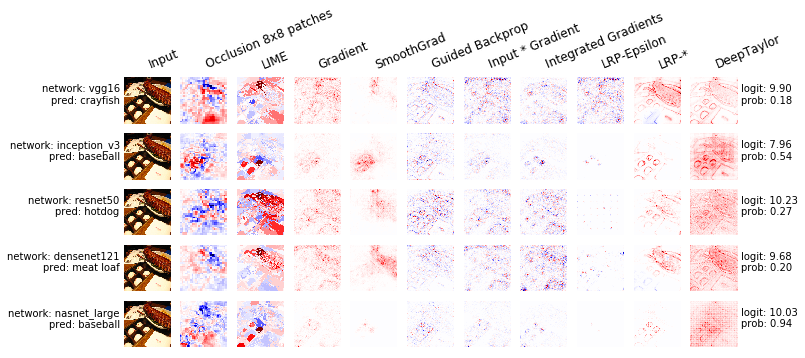

IndexError: tuple index out of range

In [8]:
n_images = analyses[netnames[0]].shape[0]

# Prepare common labels
col_labels = [''.join(method[3]) for method in methods]

for image_index in range(n_images):
    grid = []
    row_labels_left = []
    row_labels_right = []
    
    for netname in netnames:
        analysis, text = analyses[netname], texts[netname]
        # Prepare the grid as rectengular list
        grid.append([analysis[image_index, j] for j in range(analysis.shape[1])])
        # Prepare the labels
        label, presm, prob, pred = zip(*text)
        label = label[image_index]
        row_labels_left.append(('network: {}'.format(netname),'pred: {}'.format(pred[image_index])))
        row_labels_right.append(('logit: {}'.format(presm[image_index]),'prob: {}'.format(prob[image_index])))

    # Plot the analysis.
    print("Image nr. {}, true label: {}".format(image_index, label))
    file_name = os.environ.get("PLOTFILENAME", "compare_networks.pdf")
    if file_name is not None:
        file_name = ".".join(file_name.split(".")[:-1])+("_%i." % image_index)+file_name.split(".")[-1]
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels,
                           file_name=file_name)

This figures show the analysis regarding the *actually predicted* class as computed by the selected analyzers. Each column shows the visualized results for different analyzers and each row shows the analyses wrt to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).